In [2]:
import pandas as pd
import yfinance as yf
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [10]:
def backtest_static_portfolio(weights, database, ben="^GSPC", timeframe=252, CR=False):
    """
    -----------------------------------------------------------------------------
    | Output: Backtest static portfolio                                         |
    -----------------------------------------------------------------------------
    | Inputs: - weights (type 1d array numpy): weights of the portfolio         |
    |         - database (type dataframe pandas): Returns of the asset          |
    |         - ben (type string): Name of the benchmark                        |
    |         - timeframe (type int): annualization factor                      |
    -----------------------------------------------------------------------------
    """
    import pandas as pd
    import yfinance as yf
    import numpy as np
    from scipy.optimize import minimize
    import matplotlib.pyplot as plt
    plt.style.use('seaborn')


    # Compute the portfolio
    portfolio = np.multiply(database,np.transpose(weights))
    portfolio = portfolio.sum(axis=1)
    columns = database.columns
    columns = [col for col in columns]

    ######################### COMPUTE THE BETA ##################################
    # Import the benchmark
    benchmark = yf.download(ben)["Adj Close"].pct_change(1).dropna()

    # Concat the asset and the benchmark
    join = pd.concat((portfolio, benchmark), axis=1).dropna()

    # Covariance between the asset and the benchmark
    cov = np.cov(join, rowvar=False)[0][1]

    # Compute the variance of the benchmark
    var = np.cov(join, rowvar=False)[1][1]

    beta = cov/var


    ######################### COMPUTE THE ALPHA #################################
    # Mean of returns for the asset
    mean_stock_return = join.iloc[:,0].mean()*timeframe

    # Mean of returns for the market
    mean_market_return = join.iloc[:,1].mean()*timeframe

    # Alpha
    alpha = mean_stock_return - beta*mean_market_return


    ######################### COMPUTE THE SHARPE ################################
    mean = portfolio.mean() * timeframe
    std = portfolio.std() * np.sqrt(timeframe)
    Sharpe = mean/std


    ######################### COMPUTE THE SORTINO ###############################
    downward = portfolio[portfolio<0]
    std_downward = downward.std() * np.sqrt(timeframe)
    Sortino = mean/std_downward


    ######################### COMPUTE THE DRAWDOWN ###############################
    # Compute the cumulative product returns
    cum_rets = (portfolio+1).cumprod()

    # Compute the running max
    running_max = np.maximum.accumulate(cum_rets.dropna())
    running_max[running_max < 1] = 1

    # Compute the drawdown
    drawdown = ((cum_rets)/running_max - 1)
    min_drawdon = -drawdown.min()


    ######################### COMPUTE THE VaR ##################################
    theta = 0.01
    # Number of simulations
    n = 100000

    # Find the values for theta% error threshold
    t = int(n*theta)

    # Create a vector with n simulations of the normal law
    vec = pd.DataFrame(np.random.normal(mean, std, size=(n,)),
                      columns = ["Simulations"])

    # Orderer the values and find the theta% value
    VaR = -vec.sort_values(by="Simulations").iloc[t].values[0]


    ######################### COMPUTE THE cVaR #################################
    cVaR = -vec.sort_values(by="Simulations").iloc[0:t,:].mean().values[0]

    ######################### COMPUTE THE RC ###################################
    if CR:
    # Find the number of the asset in the portfolio
        l = len(weights)

        # Compute the risk contribution of each asset
        crs = []
        for i in range(l):
            # Importation of benchmark
            benchmark = yf.download(ben)["Adj Close"].pct_change(1).dropna()

            # Concat the asset and the benchmark
            join = pd.concat((database.iloc[:,i], benchmark), axis=1).dropna()

            # Covariance between the asset and the benchmark
            cov = np.cov(join, rowvar=False)[0][1]

            # Compute the variance of the benchmark
            var = np.cov(join, rowvar=False)[1][1]

            beta_s = cov/var
            cr = beta_s * weights[i]
            crs.append(cr)

        crs = crs/np.sum(crs) # Normalizing by the sum of the risk contribution

    ######################### PLOT THE RESULTS #################################
    print(f"""
    -----------------------------------------------------------------------------
    Portfolio: {columns}
    -----------------------------------------------------------------------------
    Beta: {np.round(beta, 3)} \t Alpha: {np.round(alpha*100, 2)} %\t \
    Sharpe: {np.round(Sharpe, 3)} \t Sortino: {np.round(Sortino, 3)}
    -----------------------------------------------------------------------------
    VaR: {np.round(VaR*100, 2)} %\t cVaR: {np.round(cVaR*100, 2)} % \t \
    VaR/cVaR: {np.round(cVaR/VaR, 3)} \t drawdown: {np.round(min_drawdon*100, 2)} %
    -----------------------------------------------------------------------------
    """)


    plt.figure(figsize=(15,8))
    plt.plot(join.iloc[:,0].cumsum()*100, color="#035593", linewidth=3)
    plt.plot(join.iloc[:,1].cumsum()*100, color="#068C72", linewidth=3)
    plt.title("CUMULTATIVE RETURN", size=15)
    plt.ylabel("Cumulative return %", size=15)
    plt.xticks(size=15,fontweight="bold")
    plt.yticks(size=15,fontweight="bold")
    plt.legend(["Strategy", "Benchmark"])
    plt.show()

    plt.figure(figsize=(15,8))
    plt.fill_between(drawdown.index, drawdown*100, 0, color="#CE5151")
    plt.plot(drawdown.index,drawdown*100, color="#930303", linewidth=1.5)
    plt.title("DRAWDOWN", size=15)
    plt.ylabel("Drawdown %", size=15)
    plt.xticks(size=15,fontweight="bold")
    plt.yticks(size=15,fontweight="bold")
    plt.show()



    if CR:
        plt.figure(figsize=(15,8))
        plt.scatter(columns, crs, linewidth=3, color = "#B96553")
        plt.axhline(0, color="#53A7B9")
        plt.grid(axis="x")
        plt.title("RISK CONTRIBUTION PORTFOLIO", size=15)
        plt.xlabel("Assets")
        plt.ylabel("Risk contribution")
        plt.xticks(size=15,fontweight="bold")
        plt.yticks(size=15,fontweight="bold")
        plt.show()
        plt.show()

In [12]:
# Importation of data
list_tickers = ["META", "NFLX", "TSLA"]
database = yf.download(list_tickers)

# Take only the adjusted stock price
database = database["Adj Close"]

database

[*********************100%***********************]  3 of 3 completed


,META,NFLX,TSLA
Date,,,
2002-05-23,NaN,1.196429,NaN
2002-05-24,NaN,1.210000,NaN
2002-05-28,NaN,1.157143,NaN
2002-05-29,NaN,1.103571,NaN
2002-05-30,NaN,1.071429,NaN
...,...,...,...
2022-12-12,114.709999,315.179993,167.820007
2022-12-13,120.150002,320.339996,160.949997
2022-12-14,121.589996,317.829987,156.800003


In [13]:
# Drop missing values
data = database.dropna().pct_change(1).dropna()

In [14]:
def MV_criterion(weights, data):
    """
    -----------------------------------------------------------------------------
    | Output: optimization porfolio criterion                                   |
    -----------------------------------------------------------------------------
    | Inputs: -weight (type ndarray numpy): Wheight for portfolio               |
    |         -data (type ndarray numpy): Returns of stocks                     |
    -----------------------------------------------------------------------------
    """

    # Parameters
    Lambda = 3
    W = 1
    Wbar = 1 + 0.25 / 100

    # Compute portfolio returns
    portfolio_return = np.multiply(data, np.transpose(weights))
    portfolio_return = portfolio_return.sum(axis=1)

    # Compute mean and volatility of the portfolio
    mean = np.mean(portfolio_return, axis=0)
    std = np.std(portfolio_return, axis=0)

    # Compute the criterion
    criterion = Wbar ** (1 - Lambda) / (1 + Lambda) + Wbar ** (-Lambda) \
                * W * mean - Lambda / 2 * Wbar ** (-1 - Lambda) * W ** 2 * std ** 2
    criterion = -criterion
    
    return criterion

In [15]:
# Define train and test sets
split = int(0.7 * len(data))

train_set = data.iloc[:split, :]
test_set = data.iloc[split:, :]

# Find the number of asset
n = data.shape[1]

# Initialisation weight value
x0 = np.ones(n)

# Optimization constraints problem
cons = ({'type': 'eq', 'fun': lambda x: sum(abs(x)) - 1})

# Set the bounds
Bounds = [(0, 1) for i in range(0, n)]

# Optimization problem solving
res_MV = minimize(MV_criterion, x0, method="SLSQP",
                  args=(train_set), bounds=Bounds,
                  constraints=cons, options={'disp': True})

# Result for computations
X_MV = res_MV.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.24983915443649898
            Iterations: 2
            Function evaluations: 8
            Gradient evaluations: 2


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Portfolio: ['META', 'NFLX', 'TSLA']
    -----------------------------------------------------------------------------
    Beta: 1.227 	 Alpha: 21.12 %	     Sharpe: 0.78 	 Sortino: 1.021
    -----------------------------------------------------------------------------
    VaR: 68.2 %	 cVaR: 83.2 % 	     VaR/cVaR: 1.22 	 drawdown: 59.99 %
    -----------------------------------------------------------------------------
    


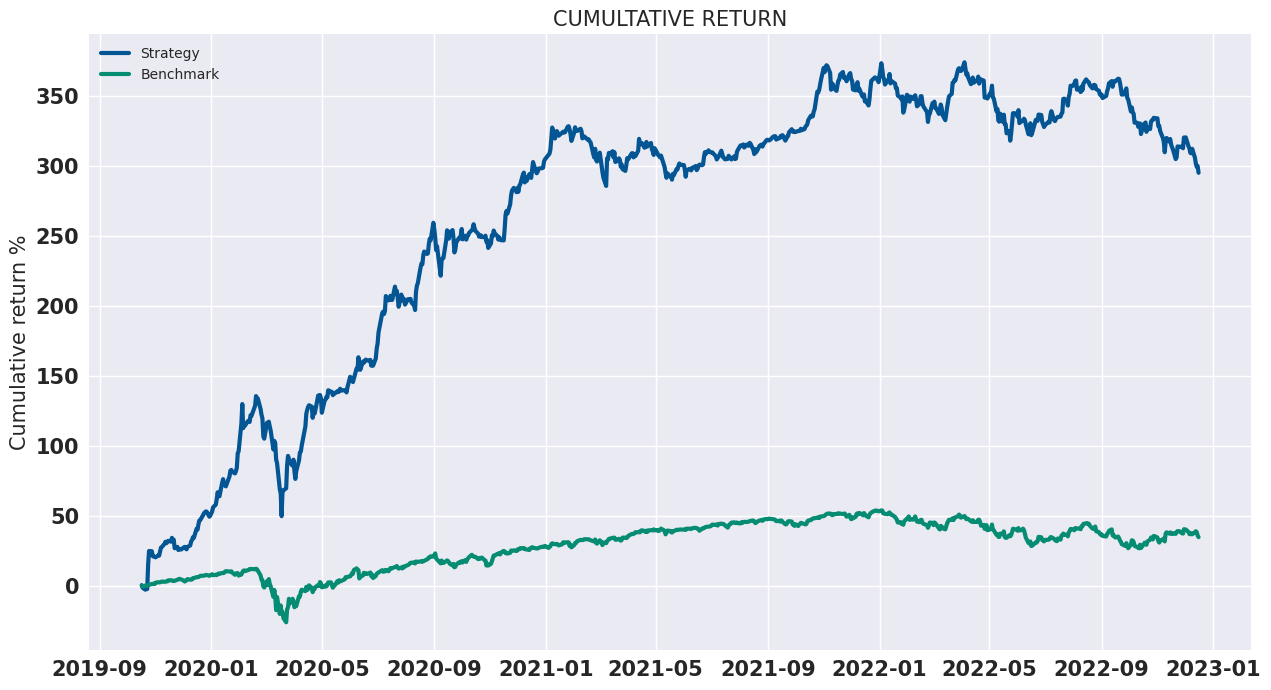

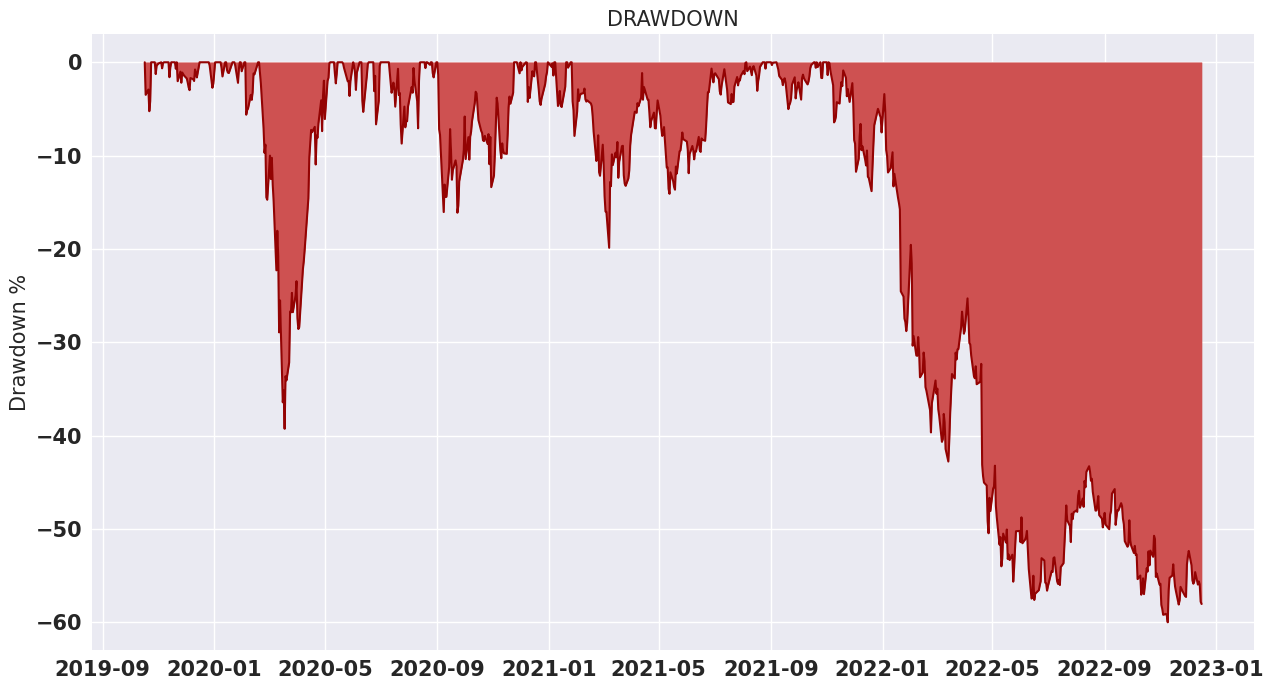

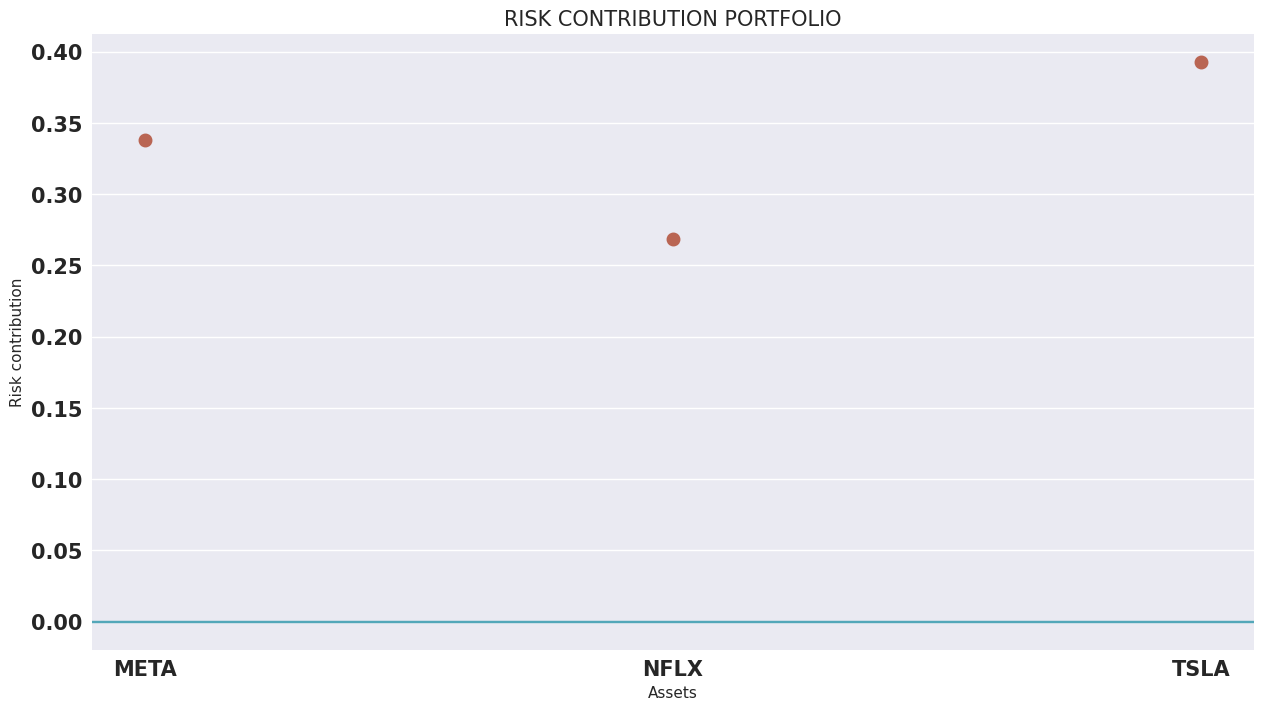

In [16]:
backtest_static_portfolio(X_MV, test_set, ben="^GSPC", timeframe=252, CR=True)